In [27]:
%config Completer.use_jedi = False

# import ipywidgets as widgets
import pandas as pd
from datetime import datetime

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import glob

import numpy as np

import seaborn as sns

## Load and Preprocess the underlying data

In [28]:
import os

In [29]:
DATA_PATH = '../Data/'
os.listdir(DATA_PATH)

['.._Data_pubmed_2021_1.0.0_fa81f1f60388c203c566127dcfbc34fa9ee3105d04b3670ab6db032ff708773d.lock',
 '.ipynb_checkpoints',
 'AllVAERSDataCSVS',
 'AllVAERSDataCSVS.zip',
 'BANKNIFTY',
 'downloads',
 'Nifty',
 'pubmed']

In [30]:
os.path.join(DATA_PATH, 'Nifty/Options/*.csv')

'../Data/Nifty/Options/*.csv'

In [31]:
data_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob(os.path.join(DATA_PATH, 'Nifty/OHLC/*.csv'),)], 
                    join='outer')

options_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob(os.path.join(DATA_PATH, 'Nifty/Options/*.csv'),)], 
                    join='outer')

# Filter for latest data
options_df = options_df[options_df.index.max()==options_df.index]

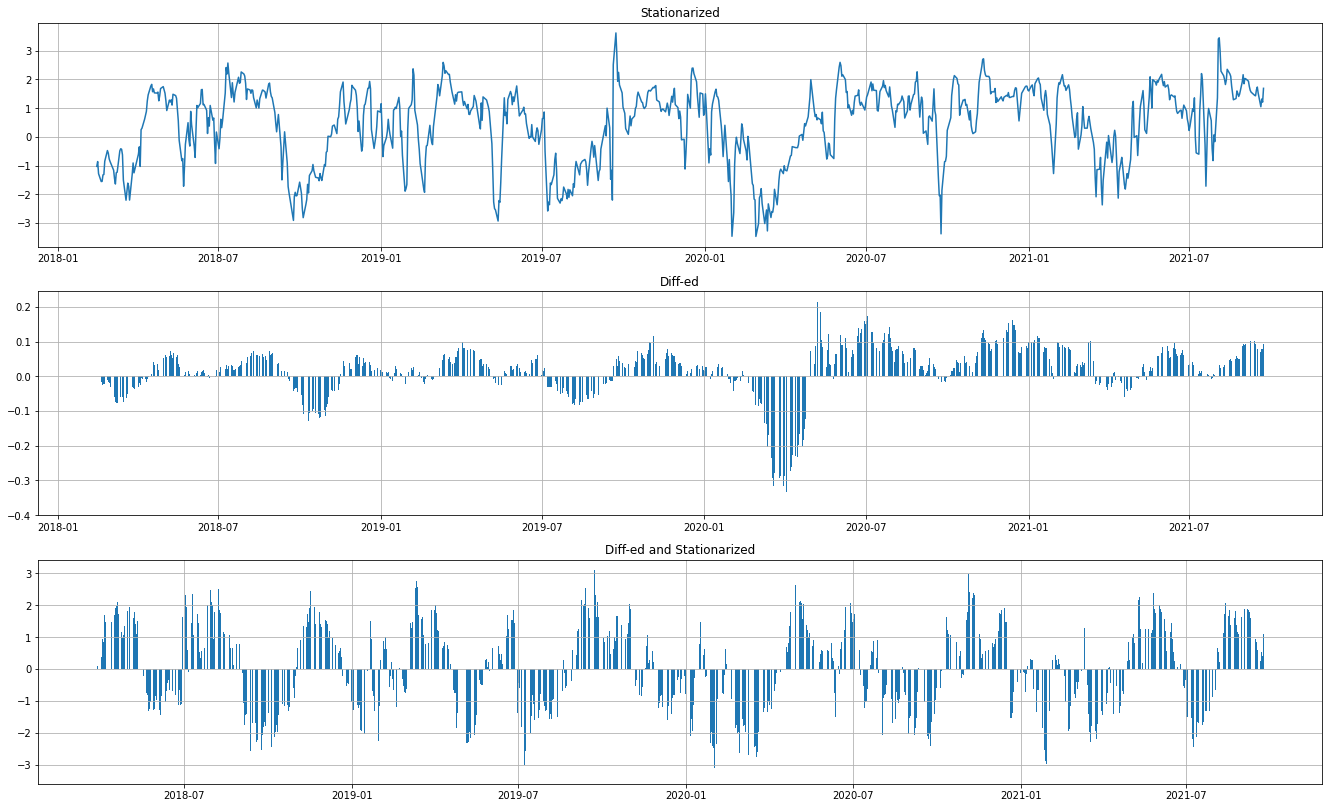

In [7]:
period = 30 # used as window size for smoothing
fig = plt.figure(figsize=(23,14))
ax = fig.add_subplot(311)
ax.plot(data_df.Close.rolling(period).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()
ax.set_title('Stationarized')
ax = fig.add_subplot(312)
ax.bar(data_df.index, data_df.Close.rolling(period).apply(lambda x: (x[-1]-x[0])/x[0]))
ax.set_title('Diff-ed')
ax.grid()
ax = fig.add_subplot(313)
ax.bar(data_df.index, data_df.Close.rolling(period).apply(lambda x: (x[-1]-x[0])).rolling(period).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.set_title('Diff-ed and Stationarized')
# ax.bar(data_df.index, (data_df.Open - data_df.Close).rolling(20).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()

In [8]:
trade_days_left = 5 # used as window size
period_change = data_df.Close.rolling(trade_days_left).apply(lambda x: (x[-1]-x[0])/x[0]).dropna()

period_open = data_df.Open.rolling(trade_days_left).apply(lambda x: x[0]).dropna()

period_high = data_df.High.rolling(trade_days_left).apply(lambda x: x.max()).dropna()

period_low = data_df.Low.rolling(trade_days_left).apply(lambda x: x.min()).dropna()

period_pos_change = (period_high - period_open)/period_open
period_neg_change = (period_low - period_open)/period_open

underlying_period_delta = pd.DataFrame({'delta':period_change, 'delta_max':period_pos_change, 'delta_min':period_neg_change}, )

Let's visualize the distribution of how much the underlying can change within the period

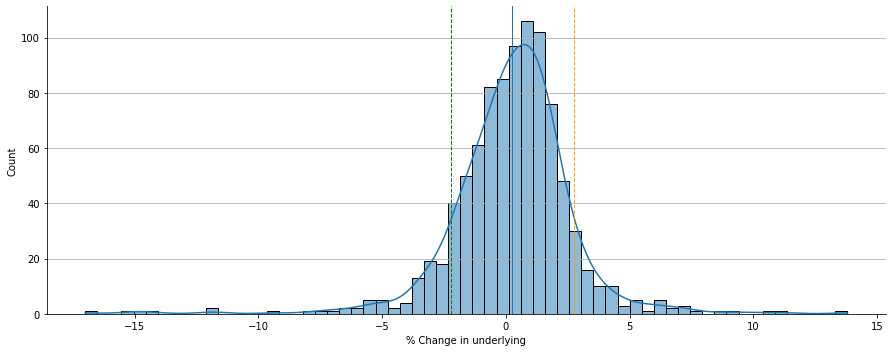

In [26]:
# fig = plt.figure(figsize=(23,14))

ax = sns.displot(data=underlying_period_delta['delta']*100,kde=True, aspect=2.5)

ax.set_axis_labels(x_var='% Change in underlying')


plt.grid(axis='y')


plt.axvline(x=100*underlying_period_delta['delta'].mean(), 
#             color='blue', 
            linewidth=1.0, 
            linestyle='-')
plt.axvline(x=100*(underlying_period_delta['delta'].mean()-underlying_period_delta['delta'].std()), 
            color='green', 
            linewidth=1.0, 
            linestyle='--')
plt.axvline(x=100*(underlying_period_delta['delta'].mean()+underlying_period_delta['delta'].std()), 
            color='orange', 
            linewidth=1.0, 
            linestyle='--')


# Probability of change
**Probability of $mean \pm \sigma$ change**

In [72]:
expected_change_neg_sigma = underlying_period_delta['delta'].mean() - underlying_period_delta['delta'].std()
prob_change_neg_sigma = (underlying_period_delta['delta']<expected_change_neg_sigma).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of < %.2f%% change" %(prob_change_neg_sigma, expected_change_neg_sigma*100))

expected_change_pos_sigma = underlying_period_delta['delta'].mean() + underlying_period_delta['delta'].std()
prob_change_pos_sigma = (underlying_period_delta['delta']>expected_change_pos_sigma).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of > %.f%% change" %(prob_change_pos_sigma, expected_change_pos_sigma*100))

**Probability of $\pm 1$% change**

In [73]:
expected_change = 0.01
prob_change = (underlying_period_delta['delta']>expected_change).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of > %.f%% change" %(prob_change, expected_change*100))

prob_change = (underlying_period_delta['delta']<-expected_change).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of < -%.f%% change" %(prob_change, expected_change*100))

0.367 probability of > 1% change
0.233 probability of < -1% change


**Probability of $\pm 2$% change**

In [74]:
expected_change = 0.02
prob_change = (underlying_period_delta['delta']>expected_change).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of > %.f%% change" %(prob_change, expected_change*100))

prob_change = (underlying_period_delta['delta']<-expected_change).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of < -%.f%% change" %(prob_change, expected_change*100))

0.159 probability of > 2% change
0.110 probability of < -2% change


**Probability of hitting upper levels and lower levels**

In [76]:
# Set the last price
last_price = 17562

In [78]:
# Set the last price
last_price = data_df.Close[-1]

In [79]:
upper_level = 17950
expected_change = (upper_level - last_price)/last_price
prob_change = (underlying_period_delta['delta']>expected_change).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of expiring above %d" %(prob_change, upper_level))

lower_level = 17450
expected_change = (lower_level - last_price)/last_price
prob_change = (underlying_period_delta['delta']<expected_change).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of expiring below %d" %(prob_change, lower_level))

0.427 probability of expiring above 17950
0.103 probability of expiring below 17450


In [80]:
upper_level = 17950
expected_change = (upper_level - last_price)/last_price
prob_change = (underlying_period_delta['delta_max']>expected_change).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of reaching %d in %d days" %(prob_change, upper_level, trade_days_left))

lower_level = 17450
expected_change = (lower_level - last_price)/last_price
prob_change = (underlying_period_delta['delta_min']<expected_change).sum()/len(underlying_period_delta['delta'])
print("%.3f probability of reaching %d in %d days" %(prob_change, lower_level, trade_days_left))

0.687 probability of reaching 17950 in 5 days
0.301 probability of reaching 17450 in 5 days


In [81]:
# Get rid of contracts which are not actively traded
options_df = options_df[options_df['No. of contracts']>1000]

In [82]:
upper_bound = 18750
lower_bound = 16750
options_df = options_df[options_df['Strike Price']<upper_bound]
options_df = options_df[options_df['Strike Price']>lower_bound]

In [83]:
def add_option_lines(ce_positions, pe_positions, last_price=None, line_width=2.0):
    if last_price is not None:
        plt.axvline(x=last_price, color='royalblue', linewidth=line_width, linestyle='--', label="Last Close: %d"%last_price)
        
    for ce_contract in ce_positions:
        plt.axvline(x=ce_contract, color='darkgreen', linewidth=line_width, linestyle='--', label="%d CE"%ce_contract)
    
    for pe_contract in pe_positions:
        plt.axvline(x=pe_contract, color='tomato', linewidth=line_width, linestyle='--', label="%d PE"%pe_contract)

In [105]:
capital = 7100
lot_size = 50
expected_rate = 0.1
# tax = 20 # placeholder in Rs
# capital_breakeven = (capital*(1+expected_rate)+tax)/lot_size

capital_breakeven = (capital/lot_size)

In [106]:

# Separate out Call and Put option
ce_df = options_df[options_df['Option Type']=='CE']
pe_df = options_df[options_df['Option Type']=='PE']

# Filter out ITM
ce_df = ce_df[ce_df['Strike Price']>last_price]
pe_df = pe_df[pe_df['Strike Price']<last_price]


ce_df = ce_df.sort_values('Strike Price')
pe_df = pe_df.sort_values('Strike Price')

# Filter out options we can't invest in due to capital constraints
ce_df = ce_df[(ce_df['LTP']*lot_size)<capital]
pe_df = pe_df[(pe_df['LTP']*lot_size)<capital]

# Change percent required to break even on the full capital
ce_change_breakeven = ((ce_df['Strike Price'] + capital_breakeven - last_price)/last_price).values
pe_change_breakeven = ((pe_df['Strike Price'] - capital_breakeven - last_price)/last_price).values

# Change percent
ce_change = ((ce_df['Strike Price'] - last_price)/last_price).values
pe_change = ((pe_df['Strike Price'] - last_price)/last_price).values


# Calculate Probabilty of call options breeaking even on the entire capital
proba_breakeven_ce = np.zeros_like(ce_change_breakeven)
for idx in range(len(ce_df)):
    proba_breakeven_ce[idx] = np.apply_along_axis(lambda x : x > ce_change_breakeven[idx],
                                                   axis=0,
                                                   arr=underlying_period_delta['delta_max']).mean()
#                                                    arr=underlying_period_delta['delta']).mean()

strike_price_ce = ce_df['Strike Price'].values

# Calculate Probabilty of out of the money put options expiring in the moeny
proba_breakeven_pe = np.zeros_like(pe_change_breakeven)
for idx in range(len(pe_df)):
    proba_breakeven_pe[idx] = np.apply_along_axis(lambda x : x < pe_change_breakeven[idx],
                                                axis=0,
                                                arr=underlying_period_delta['delta_min']).mean()
#                                                 arr=underlying_period_delta['delta']).mean()

strike_price_pe = pe_df['Strike Price'].values

# Calculate Probabilty of out of the money call options expiring in the money
proba_atm_expiry_ce = np.zeros_like(ce_change)
for idx in range(len(ce_df)):
    proba_atm_expiry_ce[idx] = np.apply_along_axis(lambda x : x > ce_change[idx],
                                                   axis=0,
                                                   arr=underlying_period_delta['delta']).mean()


# Calculate Probabilty of out of the money put options expiring in the moeny
proba_atm_expiry_pe = np.zeros_like(pe_change)
for idx in range(len(pe_df)):
    proba_atm_expiry_pe[idx] = np.apply_along_axis(lambda x : x < pe_change[idx],
                                                axis=0,
                                                arr=underlying_period_delta['delta']).mean()

sigma_high = last_price*(1+expected_change_pos_sigma)
sigma_low = last_price*(1+expected_change_neg_sigma)
# Profits when underlying expires at mean +/- std
probable_profits_ce = lot_size*(sigma_high-strike_price_ce)
probable_profits_pe = lot_size*(strike_price_pe-sigma_low)

# Zero out the loss making contracts
probable_profits_pe[probable_profits_pe<0] = 0
probable_profits_ce[probable_profits_ce<0] = 0


In [151]:
ce_positions = [18050]
pe_positions = [17750]

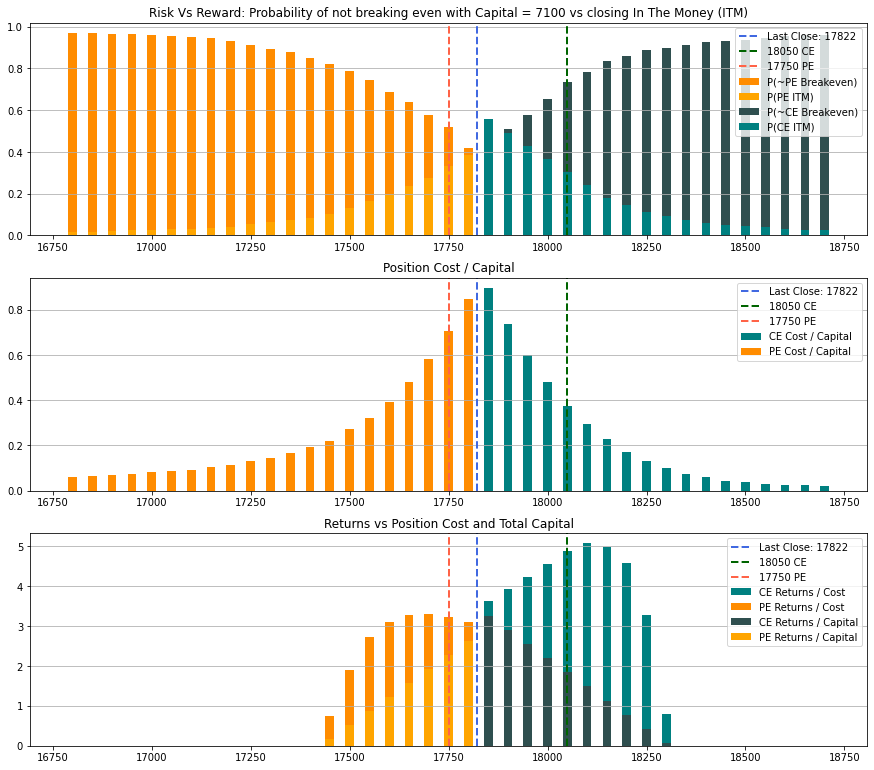

In [152]:
cost_ce = lot_size*ce_df['Close'].values
cost_pe = lot_size*pe_df['Close'].values

# Break Even Analysis
fig = plt.figure(figsize=(15,18))

ax = fig.add_subplot(411)



# Plot PE
ax.bar(x=strike_price_pe, 
       height=1-proba_breakeven_pe, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='P(~PE Breakeven)')


# Plot PE
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, 
       width=22,
       color='orange', 
       align='center', 
       label='P(PE ITM)')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=1-proba_breakeven_ce, 
       width=22, 
       color='darkslategray', 
       align='center', 
       label='P(~CE Breakeven)')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_atm_expiry_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='P(CE ITM)')


# ax.grid()
ax.set_title('Risk Vs Reward: Probability of not breaking even with Capital = %d vs closing In The Money (ITM)'%capital)


add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)
ax.legend()
ax.grid(axis='y')



# Probable profit analysis

ax = fig.add_subplot(413)

ax.set_title('Returns vs Position Cost and Total Capital')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE Returns / Cost')


# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/cost_pe, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='PE Returns / Cost')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/capital, 
       width=22, 
       color='darkslategray', 
       align='center', 
       label='CE Returns / Capital')


# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/capital, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE Returns / Capital')

add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)
ax.legend()
ax.grid(axis='y')

ax = fig.add_subplot(412)

ax.set_title('Position Cost / Capital')

# Plot CE
ax.bar(x=strike_price_ce, 
       height= cost_ce/capital, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE Cost / Capital')


add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)

# Plot PE
ax.bar(x=strike_price_pe, 
       height= cost_pe/capital, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='PE Cost / Capital')

ax.legend()
ax.grid(axis='y')




In [153]:
cost_ce = lot_size*ce_df['Close'].values
cost_pe = lot_size*pe_df['Close'].values

ce_positions_df = pd.DataFrame({'cost':cost_ce/capital,
                                'price':ce_df['Close'].values,
                                'strike_price':strike_price_ce, 
                                'p_breakeven':proba_breakeven_ce, 
                                'p_atm_expiry':proba_atm_expiry_ce,
                                'sigma_returns':probable_profits_ce/capital,
                                'option_type':'CE'
                               })


pe_positions_df = pd.DataFrame({'cost':cost_pe/capital, 
                                'price':pe_df['Close'].values,
                                'strike_price':strike_price_pe, 
                                'p_breakeven':proba_breakeven_pe, 
                                'p_atm_expiry':proba_atm_expiry_pe,
                                'sigma_returns':probable_profits_pe/capital,
                                'option_type':'PE'
                               })



pe_positions = pe_positions_df.to_dict(orient='records')
ce_positions = ce_positions_df.to_dict(orient='records')

In [140]:
position_pairs = []

for pe_position in pe_positions:

    if pe_position['sigma_returns'] < 0.5:
        continue
    for ce_position in ce_positions:
        if ce_position['sigma_returns'] < 0.5:
            continue
        
        pair_cost = pe_position['cost'] + ce_position['cost']
        if pair_cost < 1:
            position_pair = {'cost': pair_cost}
            position_pair['p_not_breakeven'] = (1-pe_position['p_breakeven'])*(1-ce_position['p_breakeven'])
            position_pair['pe'] = pe_position['strike_price']
            position_pair['ce'] = ce_position['strike_price']
            position_pair['pe_returns'] = pe_position['sigma_returns']
            position_pair['ce_returns'] = ce_position['sigma_returns']
            position_pair['pe_price'] = pe_position['price']
            position_pair['ce_price'] = ce_position['price']
            
            position_pairs.append(position_pair)
        

In [141]:
position_pairs = pd.DataFrame(position_pairs)

position_pairs.loc[position_pairs.p_not_breakeven.argmin()]

cost                   0.993310
p_not_breakeven        0.395347
pe                 17600.000000
ce                 17950.000000
pe_returns             1.222801
ce_returns             2.542582
pe_price              55.850000
ce_price              85.200000
Name: 12, dtype: float64

In [142]:
position_pairs = position_pairs.sort_values('p_not_breakeven')

In [143]:
position_pairs['cost'] = position_pairs['cost']*capital

In [146]:
position_pairs['breakeven_price'] = position_pairs['pe_price']+position_pairs['ce_price']

In [149]:
position_pairs['spread'] = position_pairs.ce-position_pairs.pe

In [150]:
position_pairs

,cost,p_not_breakeven,pe,ce,pe_returns,ce_returns,pe_price,ce_price,breakeven_price,spread
12,7052.5,0.395347,17600,17950,1.222801,2.542582,55.85,85.20,141.05,350
18,6827.5,0.416537,17650,18000,1.574913,2.190469,68.20,68.35,136.55,350
23,6802.5,0.425774,17700,18050,1.927026,1.838356,82.65,53.40,136.05,350
6,6532.5,0.428553,17550,17950,0.870688,2.542582,45.45,85.20,130.65,400
27,6635.0,0.434482,17750,18150,2.279139,1.134131,100.40,32.30,132.70,400
13,6210.0,0.447760,17600,18000,1.222801,2.190469,55.85,68.35,124.20,400
28,6235.0,0.448662,17750,18200,2.279139,0.782018,100.40,24.30,124.70,450
24,6212.5,0.451559,17700,18100,1.927026,1.486244,82.65,41.60,124.25,400
0,6187.5,0.453615,17500,17950,0.518575,2.542582,38.55,85.20,123.75,450
19,6080.0,0.471565,17650,18050,1.574913,1.838356,68.20,53.40,121.60,400


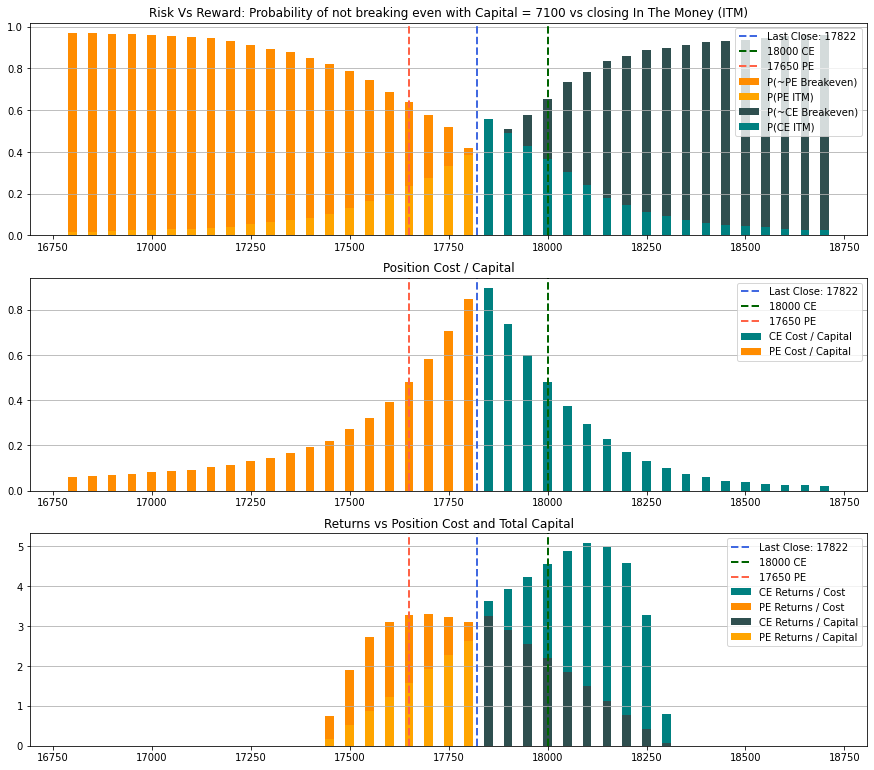

In [108]:
# Break Even Analysis
fig = plt.figure(figsize=(15,18))

ax = fig.add_subplot(411)



# Plot PE
ax.bar(x=strike_price_pe, 
       height=1-proba_breakeven_pe, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='P(~PE Breakeven)')


# Plot PE
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, 
       width=22,
       color='orange', 
       align='center', 
       label='P(PE ITM)')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=1-proba_breakeven_ce, 
       width=22, 
       color='darkslategray', 
       align='center', 
       label='P(~CE Breakeven)')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_atm_expiry_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='P(CE ITM)')


# ax.grid()
ax.set_title('Risk Vs Reward: Probability of not breaking even with Capital = %d vs closing In The Money (ITM)'%capital)


add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)
ax.legend()
ax.grid(axis='y')



# Probable profit analysis

ax = fig.add_subplot(413)

ax.set_title('Returns vs Position Cost and Total Capital')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE Returns / Cost')


# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/cost_pe, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='PE Returns / Cost')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/capital, 
       width=22, 
       color='darkslategray', 
       align='center', 
       label='CE Returns / Capital')


# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/capital, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE Returns / Capital')

add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)
ax.legend()
ax.grid(axis='y')

ax = fig.add_subplot(412)

ax.set_title('Position Cost / Capital')

# Plot CE
ax.bar(x=strike_price_ce, 
       height= cost_ce/capital, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE Cost / Capital')


add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)

# Plot PE
ax.bar(x=strike_price_pe, 
       height= cost_pe/capital, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='PE Cost / Capital')

ax.legend()
ax.grid(axis='y')